In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, Flatten
from keras.layers.recurrent import SimpleRNN, LSTM, GRU

In [2]:
tf.random.set_seed(1)

In [3]:
tf.config.list_physical_devices('GPU')

[]

In [10]:
airline_passengers_data = pd.read_csv('./Desktop/Artyom_DS/Neural_networks_int/airline-passengers.csv')

In [11]:
airline_passengers_data.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [12]:
airline_passengers_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [13]:
airline_passengers_data['Month'].value_counts()

1955-01    1
1949-02    1
1956-10    1
1953-04    1
1956-07    1
          ..
1957-08    1
1952-03    1
1954-09    1
1956-01    1
1954-12    1
Name: Month, Length: 144, dtype: int64

In [14]:
airline_passengers_data['Month'] = pd.to_datetime(airline_passengers_data['Month'], format='%Y-%m')

In [15]:
def parse_date(df, date_feature_name):
    date_list = df[date_feature_name]
    years = []
    months = []
    for el in date_list:
        years.append(el.year)
        months.append(el.month)
    df['year'] = years
    df['mon'] = months

    return df

In [16]:
airline_passengers_data = parse_date(airline_passengers_data, 'Month')

In [17]:
data = airline_passengers_data.iloc[:, 1:]
data.head()

,Passengers,year,mon
0,112,1949,1
1,118,1949,2
2,132,1949,3
3,129,1949,4
4,121,1949,5


In [18]:
train_size = 100


# список признаков, по которым будем учить
features = ['Passengers', 'year', 'mon']


# отступ теста от тренировки
bias = 5


# делим
train_data = data.iloc[:train_size][features]
val_data = data.iloc[train_size + bias:][features]

train_data.shape, val_data.shape

((100, 3), (39, 3))

In [19]:
features = train_data.columns[1:]
target = train_data.columns[0]

In [20]:
scaler = StandardScaler()

train_data[features] = scaler.fit_transform(train_data[features])
val_data[features] = scaler.transform(val_data[features])

train_data.head()

,Passengers,year,mon
0,112,-1.525724,-1.534863
1,118,-1.525724,-1.247435
2,132,-1.525724,-0.960008
3,129,-1.525724,-0.672580
4,121,-1.525724,-0.385153


In [21]:
# длина истории
x_len = 3

# горизонт предсказания
future = 1

# параметры модели для обучения
learning_rate = 0.001
batch_size = 8
epochs = 10

In [22]:
start = x_len + future
end = start + train_size

print(start, end)

X_train = train_data[features].values
y_train = data.iloc[start:end][target].values


x_end = len(val_data) - x_len - future
label_start = len(train_data) + bias + x_len + future
print(x_end, label_start)

X_val = val_data.iloc[:x_end][features].values
y_val = data.iloc[label_start:][target].values

4 104
35 109


In [23]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((100, 2), (100,), (35, 2), (35,))

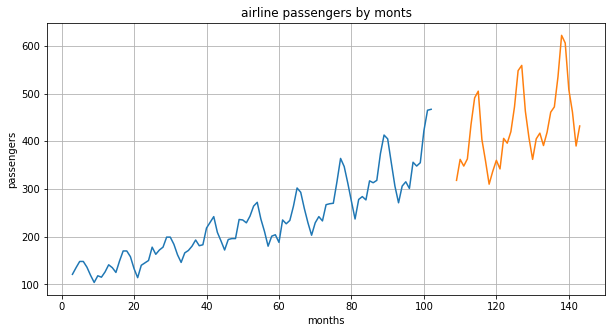

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(data.index[x_len:y_train.shape[0]+x_len],y_train[:])
plt.plot(data.index[y_train.shape[0]+x_len+bias+future:],y_val[:])
plt.grid('on')
plt.xlabel('months')
plt.ylabel('passengers')
plt.title('airline passengers by monts')
plt.show()

In [25]:
dataset_train = timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

dataset_val = timeseries_dataset_from_array(
    X_val,
    y_val,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

In [26]:
for batch in dataset_train.take(1):
    inputs, targets = batch
    print("Input shape:", inputs.shape)
    print(inputs[1])
    print("Target shape:", targets.shape)
    print(targets[1])

Input shape: (8, 3, 2)
tf.Tensor(
[[-1.52572369 -1.24743549]
 [-1.52572369 -0.96000796]
 [-1.52572369 -0.67258043]], shape=(3, 2), dtype=float64)
Target shape: (8,)
tf.Tensor(135, shape=(), dtype=int64)


In [27]:
results = pd.DataFrame() # сводная таблица результатов
model = [] # шаг
train_m = [] # результат на трейне
test_m = [] # результат на тесте

In [28]:
early_stop = EarlyStopping(monitor='val_mae', patience=5)

model_1 = Sequential()

model_1.add(SimpleRNN(32, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model_1.add(Conv1D(64, 3, activation='linear'))
model_1.add(Conv1D(64, 1, activation='linear'))
model_1.add(Flatten())
model_1.add(Dense(3, activation='linear'))
model_1.add(Dense(1, activation='linear'))

model_1.compile(loss='mse', optimizer='adam', metrics=['mae'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 3, 32)             1120      
_________________________________________________________________
conv1d (Conv1D)              (None, 1, 64)             6208      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 64)             4160      
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 195       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4         
Total params: 11,687
Trainable params: 11,687
Non-trainable params: 0
____________________________________________________

In [29]:
history_1 = model_1.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/10
13/13 [==============================] - 2s 42ms/step - loss: 35845.9127 - mae: 179.4417 - val_loss: 195057.7344 - val_mae: 434.3455
Epoch 2/10
13/13 [==============================] - 0s 8ms/step - loss: 35505.8812 - mae: 178.4158 - val_loss: 193480.7500 - val_mae: 432.5594
Epoch 3/10
13/13 [==============================] - 0s 8ms/step - loss: 35548.1023 - mae: 178.7341 - val_loss: 191998.6094 - val_mae: 430.8818
Epoch 4/10
13/13 [==============================] - 0s 8ms/step - loss: 35498.4982 - mae: 178.8203 - val_loss: 189399.2031 - val_mae: 427.9258
Epoch 5/10
13/13 [==============================] - 0s 8ms/step - loss: 35254.9272 - mae: 178.5998 - val_loss: 183160.5781 - val_mae: 420.7308
Epoch 6/10
13/13 [==============================] - 0s 8ms/step - loss: 34374.0491 - mae: 177.3027 - val_loss: 166946.5625 - val_mae: 401.3585
Epoch 7/10
13/13 [==============================] - 0s 8ms/step - loss: 31313.2400 - mae: 171.3162 - val_loss: 127731.6953 - val_mae: 349.836

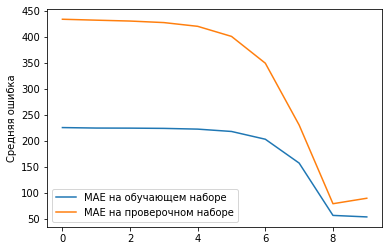

In [30]:

plt.plot(history_1.history['mae'][:], 
         label='MAE на обучающем наборе')
plt.plot(history_1.history['val_mae'][:], 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [31]:
hist_val_1 = history_1.history['val_mae']
hist_train_1 = history_1.history['mae']

In [32]:
num_iterations = 25

Epoch 1/10
13/13 [==============================] - 0s 10ms/step - loss: 1636.3710 - mae: 31.2918 - val_loss: 20042.8633 - val_mae: 121.9035
Epoch 2/10
13/13 [==============================] - 0s 14ms/step - loss: 1387.1532 - mae: 29.8463 - val_loss: 14377.1924 - val_mae: 98.3819
Epoch 3/10
13/13 [==============================] - 0s 8ms/step - loss: 1509.0908 - mae: 31.0266 - val_loss: 13719.3438 - val_mae: 95.7817
Epoch 4/10
13/13 [==============================] - 0s 8ms/step - loss: 1348.6469 - mae: 29.0808 - val_loss: 14504.1123 - val_mae: 99.9307
Epoch 5/10
13/13 [==============================] - 0s 8ms/step - loss: 1297.3875 - mae: 28.6926 - val_loss: 13678.4678 - val_mae: 96.2485
Epoch 6/10
13/13 [==============================] - 0s 8ms/step - loss: 1268.8687 - mae: 28.2431 - val_loss: 13337.0918 - val_mae: 94.8213
Epoch 7/10
13/13 [==============================] - 0s 9ms/step - loss: 1211.2451 - mae: 27.4912 - val_loss: 13134.6152 - val_mae: 94.0796
Epoch 8/10
13/13 [======

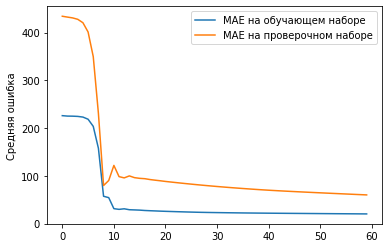

Epoch 1/10
13/13 [==============================] - 0s 9ms/step - loss: 639.2437 - mae: 20.2185 - val_loss: 5933.0122 - val_mae: 59.6611
Epoch 2/10
13/13 [==============================] - 0s 8ms/step - loss: 633.7001 - mae: 20.1311 - val_loss: 5848.7729 - val_mae: 59.1963
Epoch 3/10
13/13 [==============================] - 0s 8ms/step - loss: 628.0173 - mae: 20.0420 - val_loss: 5764.4897 - val_mae: 58.7262
Epoch 4/10
13/13 [==============================] - 0s 8ms/step - loss: 622.1731 - mae: 19.9549 - val_loss: 5679.9912 - val_mae: 58.2498
Epoch 5/10
13/13 [==============================] - 0s 8ms/step - loss: 616.1437 - mae: 19.8638 - val_loss: 5595.1138 - val_mae: 57.7662
Epoch 6/10
13/13 [==============================] - 0s 8ms/step - loss: 609.9041 - mae: 19.7680 - val_loss: 5509.6973 - val_mae: 57.2745
Epoch 7/10
13/13 [==============================] - 0s 9ms/step - loss: 603.4274 - mae: 19.6721 - val_loss: 5423.5786 - val_mae: 56.7738
Epoch 8/10
13/13 [=======================

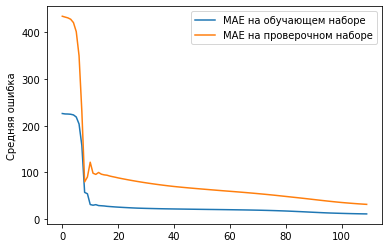

Epoch 1/10
13/13 [==============================] - 0s 10ms/step - loss: 184.3066 - mae: 11.1197 - val_loss: 1845.1251 - val_mae: 31.3147
Epoch 2/10
13/13 [==============================] - 0s 14ms/step - loss: 180.4586 - mae: 11.0156 - val_loss: 1813.1129 - val_mae: 30.9629
Epoch 3/10
13/13 [==============================] - 0s 7ms/step - loss: 176.7241 - mae: 10.9099 - val_loss: 1782.8749 - val_mae: 30.6254
Epoch 4/10
13/13 [==============================] - 0s 7ms/step - loss: 173.0937 - mae: 10.8027 - val_loss: 1754.2880 - val_mae: 30.2943
Epoch 5/10
13/13 [==============================] - 0s 8ms/step - loss: 169.5634 - mae: 10.6939 - val_loss: 1727.2322 - val_mae: 29.9692
Epoch 6/10
13/13 [==============================] - 0s 9ms/step - loss: 166.1305 - mae: 10.5837 - val_loss: 1701.6067 - val_mae: 29.7222
Epoch 7/10
13/13 [==============================] - 0s 8ms/step - loss: 162.7916 - mae: 10.4722 - val_loss: 1677.2849 - val_mae: 29.5542
Epoch 8/10
13/13 [=====================

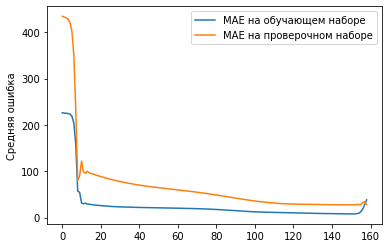

Epoch 1/10
13/13 [==============================] - 0s 10ms/step - loss: 1605.0968 - mae: 34.0403 - val_loss: 1689.8900 - val_mae: 30.3061
Epoch 2/10
13/13 [==============================] - 0s 8ms/step - loss: 597.0142 - mae: 19.5534 - val_loss: 1915.9231 - val_mae: 31.5243
Epoch 3/10
13/13 [==============================] - 0s 9ms/step - loss: 914.5263 - mae: 26.5233 - val_loss: 1701.3453 - val_mae: 30.1881
Epoch 4/10
13/13 [==============================] - 0s 8ms/step - loss: 952.4197 - mae: 26.4914 - val_loss: 1561.1990 - val_mae: 30.3309
Epoch 5/10
13/13 [==============================] - 0s 9ms/step - loss: 457.2974 - mae: 19.1692 - val_loss: 1929.1202 - val_mae: 31.9580
Epoch 6/10
13/13 [==============================] - 0s 8ms/step - loss: 259.1742 - mae: 13.9784 - val_loss: 1504.8571 - val_mae: 28.9811
Epoch 7/10
13/13 [==============================] - 0s 7ms/step - loss: 194.5754 - mae: 11.2601 - val_loss: 1666.0736 - val_mae: 29.4091
Epoch 8/10
13/13 [=====================

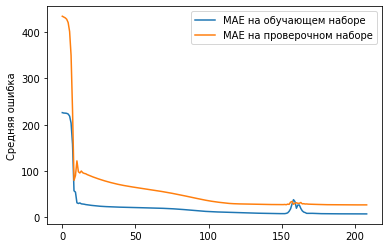

Epoch 1/10
13/13 [==============================] - 0s 10ms/step - loss: 90.0848 - mae: 7.3146 - val_loss: 1119.7325 - val_mae: 26.7528
Epoch 2/10
13/13 [==============================] - 0s 7ms/step - loss: 89.9489 - mae: 7.2835 - val_loss: 1122.1550 - val_mae: 26.7595
Epoch 3/10
13/13 [==============================] - 0s 8ms/step - loss: 89.6863 - mae: 7.3307 - val_loss: 1120.8429 - val_mae: 26.8397
Epoch 4/10
13/13 [==============================] - 0s 14ms/step - loss: 89.3707 - mae: 7.2603 - val_loss: 1115.2937 - val_mae: 26.7197
Epoch 5/10
13/13 [==============================] - 0s 8ms/step - loss: 89.0772 - mae: 7.2960 - val_loss: 1121.3340 - val_mae: 26.8589
Epoch 6/10
13/13 [==============================] - 0s 9ms/step - loss: 89.1972 - mae: 7.2996 - val_loss: 1113.7758 - val_mae: 26.8104
Epoch 7/10
13/13 [==============================] - 0s 8ms/step - loss: 89.0818 - mae: 7.2361 - val_loss: 1115.8683 - val_mae: 26.7776
Epoch 8/10
13/13 [==============================] - 0

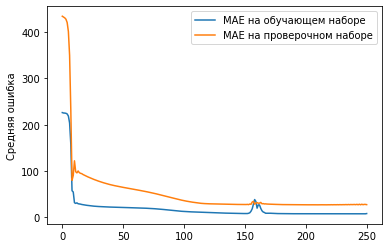

In [33]:
for iteration in range(num_iterations):
  history_1 = model_1.fit(dataset_train,
                      epochs=epochs,
                      validation_data=dataset_val,
                      callbacks=[early_stop])

  hist_val_1.extend(history_1.history['val_mae'][:])
  hist_train_1.extend(history_1.history['mae'][:])

  if (iteration + 1) % 5 == 0:
    plt.plot(hist_train_1, 
            label='MAE на обучающем наборе')
    plt.plot(hist_val_1, 
            label='MAE на проверочном наборе')

    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

In [34]:
pred_1 = model_1.predict(dataset_train).flatten()
pred_val_1 = model_1.predict(dataset_val).flatten()

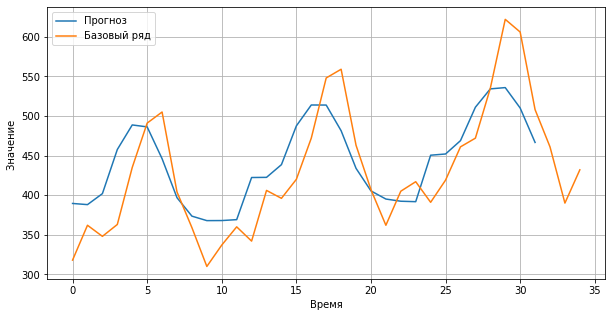

In [35]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val_1[future + start: future + start + step], 
         label='Прогноз')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

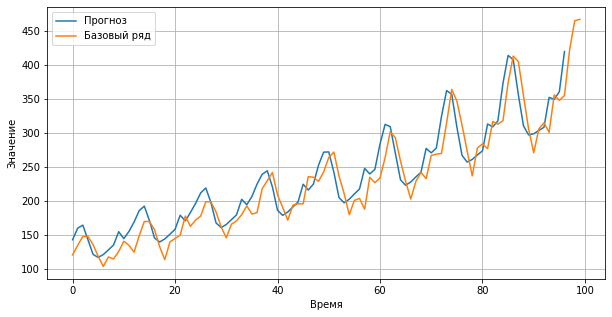

In [36]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_1[future + start: future + train_size], 
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [37]:
train_loss_1, train_m_1 = model_1.evaluate(dataset_train)
test_loss_1, test_m_1 = model_1.evaluate(dataset_val)
print(f'train_loss: {train_loss_1}, train_m: {train_m_1}')
print(f'test_loss: {test_loss_1}, test_m: {test_m_1}')

model.append('SimpleRNN')
train_m.append(round(train_m_1,2))
test_m.append(round(test_m_1,2))

5/5 [==============================] - 0s 1ms/step - loss: 1121.1062 - mae: 27.1519
train_loss: 140.85047912597656, train_m: 9.58322811126709
test_loss: 1121.106201171875, test_m: 27.15189552307129


In [38]:
early_stop = EarlyStopping(monitor='val_mae', patience=5)

model_2 = Sequential()

model_2.add(LSTM(32, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model_2.add(LSTM(32, return_sequences=True))
model_2.add(Conv1D(64, 3, activation='linear'))
model_2.add(Conv1D(64, 1, activation='linear'))
model_2.add(Flatten())
model_2.add(Dense(3, activation='linear'))
model_2.add(Dense(1, activation='linear'))

model_2.compile(loss='mse', optimizer='adam', metrics=['mae'])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 32)             4480      
_________________________________________________________________
lstm_1 (LSTM)                (None, 3, 32)             8320      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1, 64)             6208      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 64)             4160      
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [39]:
history_2 = model_2.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/10
13/13 [==============================] - 3s 65ms/step - loss: 35788.3458 - mae: 179.4531 - val_loss: 193013.9688 - val_mae: 432.0141
Epoch 2/10
13/13 [==============================] - 0s 10ms/step - loss: 35586.4470 - mae: 178.9062 - val_loss: 192117.2344 - val_mae: 430.9884
Epoch 3/10
13/13 [==============================] - 0s 10ms/step - loss: 35045.8933 - mae: 177.5145 - val_loss: 188936.7344 - val_mae: 427.3466
Epoch 4/10
13/13 [==============================] - 0s 10ms/step - loss: 33261.4385 - mae: 172.8963 - val_loss: 177701.0469 - val_mae: 414.2892
Epoch 5/10
13/13 [==============================] - 0s 10ms/step - loss: 27713.1603 - mae: 157.7590 - val_loss: 142468.5938 - val_mae: 370.5146
Epoch 6/10
13/13 [==============================] - 0s 10ms/step - loss: 13797.2778 - mae: 110.3395 - val_loss: 62030.3984 - val_mae: 241.3007
Epoch 7/10
13/13 [==============================] - 0s 10ms/step - loss: 1741.7302 - mae: 31.4393 - val_loss: 8944.2305 - val_mae: 80.999

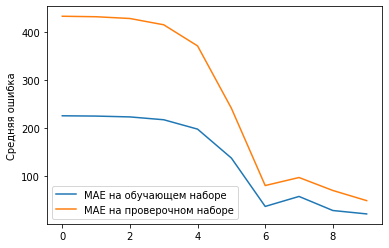

In [40]:
plt.plot(history_2.history['mae'][:], 
         label='MAE на обучающем наборе')
plt.plot(history_2.history['val_mae'][:], 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [41]:
hist_val_2 = history_2.history['val_mae']
hist_train_2 = history_2.history['mae']

In [42]:
num_iterations = 25

Epoch 1/10
13/13 [==============================] - 0s 12ms/step - loss: 735.3372 - mae: 21.3424 - val_loss: 4997.4331 - val_mae: 51.9642
Epoch 2/10
13/13 [==============================] - 0s 12ms/step - loss: 698.1332 - mae: 20.6575 - val_loss: 4601.0693 - val_mae: 49.7293
Epoch 3/10
13/13 [==============================] - 0s 12ms/step - loss: 700.9740 - mae: 20.7008 - val_loss: 4491.0884 - val_mae: 49.0998
Epoch 4/10
13/13 [==============================] - 0s 11ms/step - loss: 692.7814 - mae: 20.5691 - val_loss: 4580.8760 - val_mae: 49.5670
Epoch 5/10
13/13 [==============================] - 0s 9ms/step - loss: 688.6063 - mae: 20.5152 - val_loss: 4503.3418 - val_mae: 49.1334
Epoch 6/10
13/13 [==============================] - 0s 11ms/step - loss: 683.0427 - mae: 20.4316 - val_loss: 4505.6934 - val_mae: 49.1245
Epoch 7/10
13/13 [==============================] - 0s 10ms/step - loss: 678.5198 - mae: 20.3686 - val_loss: 4459.0845 - val_mae: 48.8399
Epoch 8/10
13/13 [=================

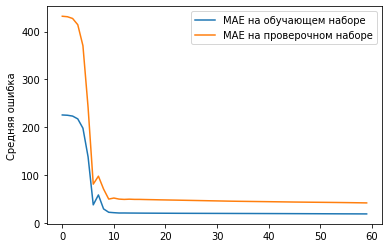

Epoch 1/10
13/13 [==============================] - 0s 11ms/step - loss: 563.2150 - mae: 18.7143 - val_loss: 3023.3982 - val_mae: 41.5775
Epoch 2/10
13/13 [==============================] - 0s 11ms/step - loss: 559.2990 - mae: 18.6631 - val_loss: 2989.8762 - val_mae: 41.3703
Epoch 3/10
13/13 [==============================] - 0s 10ms/step - loss: 555.0924 - mae: 18.6071 - val_loss: 2955.1062 - val_mae: 41.1473
Epoch 4/10
13/13 [==============================] - 0s 11ms/step - loss: 550.5600 - mae: 18.5440 - val_loss: 2918.9497 - val_mae: 40.9069
Epoch 5/10
13/13 [==============================] - 0s 10ms/step - loss: 545.6645 - mae: 18.4732 - val_loss: 2881.2578 - val_mae: 40.6791
Epoch 6/10
13/13 [==============================] - 0s 10ms/step - loss: 540.3652 - mae: 18.3978 - val_loss: 2841.8821 - val_mae: 40.4547
Epoch 7/10
13/13 [==============================] - 0s 10ms/step - loss: 534.6180 - mae: 18.3134 - val_loss: 2800.6621 - val_mae: 40.2086
Epoch 8/10
13/13 [================

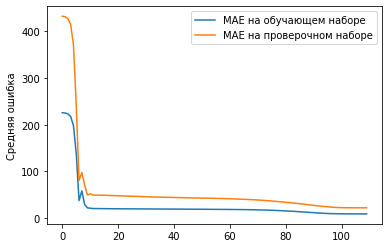

Epoch 1/10
13/13 [==============================] - 0s 17ms/step - loss: 137.7933 - mae: 9.1686 - val_loss: 704.4201 - val_mae: 22.2118
Epoch 2/10
13/13 [==============================] - 0s 10ms/step - loss: 137.4388 - mae: 9.1555 - val_loss: 702.4705 - val_mae: 22.2386
Epoch 3/10
13/13 [==============================] - 0s 10ms/step - loss: 137.0998 - mae: 9.1441 - val_loss: 701.0166 - val_mae: 22.2649
Epoch 4/10
13/13 [==============================] - 0s 10ms/step - loss: 136.7734 - mae: 9.1358 - val_loss: 699.9915 - val_mae: 22.2904
Epoch 5/10
13/13 [==============================] - 0s 10ms/step - loss: 136.4585 - mae: 9.1272 - val_loss: 699.3379 - val_mae: 22.3152
Epoch 6/10
13/13 [==============================] - 0s 10ms/step - loss: 136.1530 - mae: 9.1182 - val_loss: 699.0140 - val_mae: 22.3394
Epoch 1/10
13/13 [==============================] - 0s 11ms/step - loss: 135.8550 - mae: 9.1091 - val_loss: 698.9960 - val_mae: 22.3631
Epoch 2/10
13/13 [==============================

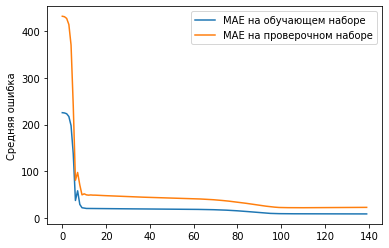

Epoch 1/10
13/13 [==============================] - 0s 11ms/step - loss: 130.4554 - mae: 8.9443 - val_loss: 745.4208 - val_mae: 23.0014
Epoch 2/10
13/13 [==============================] - 0s 10ms/step - loss: 130.2354 - mae: 8.9413 - val_loss: 749.1515 - val_mae: 23.0588
Epoch 3/10
13/13 [==============================] - 0s 10ms/step - loss: 130.0332 - mae: 8.9387 - val_loss: 752.9818 - val_mae: 23.1165
Epoch 4/10
13/13 [==============================] - 0s 10ms/step - loss: 129.9051 - mae: 8.9311 - val_loss: 755.8137 - val_mae: 23.1597
Epoch 5/10
13/13 [==============================] - 0s 10ms/step - loss: 129.8250 - mae: 8.9186 - val_loss: 757.7239 - val_mae: 23.1948
Epoch 6/10
13/13 [==============================] - 0s 10ms/step - loss: 129.6760 - mae: 8.9093 - val_loss: 760.4464 - val_mae: 23.2430
Epoch 1/10
13/13 [==============================] - 0s 18ms/step - loss: 129.3980 - mae: 8.9101 - val_loss: 765.3806 - val_mae: 23.3138
Epoch 2/10
13/13 [==============================

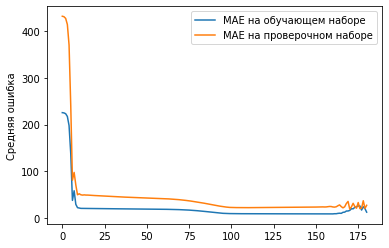

Epoch 1/10
13/13 [==============================] - 0s 11ms/step - loss: 213.7258 - mae: 11.8946 - val_loss: 1008.5020 - val_mae: 26.9848
Epoch 2/10
13/13 [==============================] - 0s 10ms/step - loss: 215.1946 - mae: 12.2955 - val_loss: 618.1686 - val_mae: 20.5888
Epoch 3/10
13/13 [==============================] - 0s 10ms/step - loss: 154.5847 - mae: 10.0402 - val_loss: 1012.5037 - val_mae: 26.9202
Epoch 4/10
13/13 [==============================] - 0s 10ms/step - loss: 121.7418 - mae: 8.5875 - val_loss: 787.1963 - val_mae: 23.4092
Epoch 5/10
13/13 [==============================] - 0s 16ms/step - loss: 123.6483 - mae: 8.5267 - val_loss: 741.1760 - val_mae: 22.5805
Epoch 6/10
13/13 [==============================] - 0s 10ms/step - loss: 121.4893 - mae: 8.5997 - val_loss: 845.9012 - val_mae: 24.3452
Epoch 7/10
13/13 [==============================] - 0s 10ms/step - loss: 117.5922 - mae: 8.3551 - val_loss: 783.4593 - val_mae: 23.3933
Epoch 1/10
13/13 [=========================

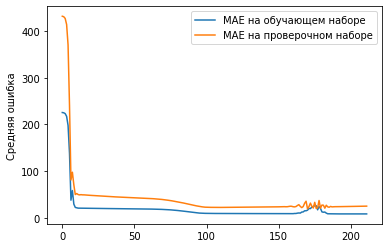

In [43]:
for iteration in range(num_iterations):
  history_2 = model_2.fit(dataset_train,
                      epochs=epochs,
                      validation_data=dataset_val,
                      callbacks=[early_stop])

  hist_val_2.extend(history_2.history['val_mae'][:])
  hist_train_2.extend(history_2.history['mae'][:])

  if (iteration + 1) % 5 == 0:
    plt.plot(hist_train_2, 
            label='MAE на обучающем наборе')
    plt.plot(hist_val_2, 
            label='MAE на проверочном наборе')

    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

In [44]:
pred_2 = model_2.predict(dataset_train).flatten()
pred_val_2 = model_2.predict(dataset_val).flatten()

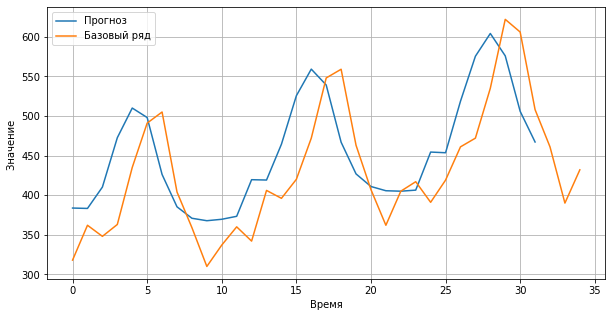

In [45]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val_2[future + start: future + start + step], 
         label='Прогноз')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

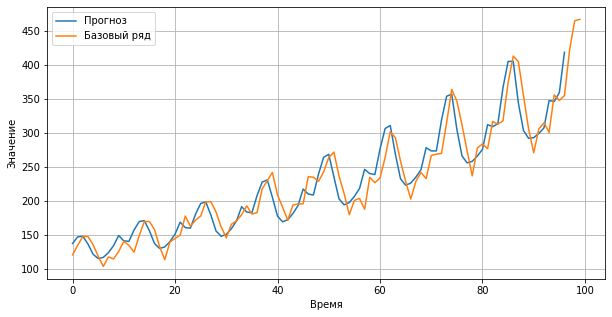

In [46]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_2[future + start: future + train_size], 
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [47]:
train_loss_2, train_m_2 = model_2.evaluate(dataset_train)
test_loss_2, test_m_2 = model_2.evaluate(dataset_val)
print(f'train_loss: {train_loss_2}, train_m: {train_m_2}')
print(f'test_loss: {test_loss_2}, test_m: {test_m_2}')

model.append('LSTM')
train_m.append(round(train_m_2,2))
test_m.append(round(test_m_2,2))

5/5 [==============================] - 0s 2ms/step - loss: 872.4564 - mae: 24.9382
train_loss: 101.80306243896484, train_m: 7.763338088989258
test_loss: 872.4563598632812, test_m: 24.938217163085938


In [48]:
# установка ряда метапареметров  для нейронной сети и процесса тренировки
batch_size = 8
hidden_size = 32
num_iterations = 25 
num_epochs = 1
num_preds = 100

In [49]:
model_3 = Sequential()
model_3.add(
    GRU(
        hidden_size,
        return_sequences=True,
        input_shape=(inputs.shape[1], inputs.shape[2]),
        unroll=True
    )
)
model_3.add(Conv1D(64, 3, activation='linear'))
model_3.add(Conv1D(64, 1, activation='linear'))
model_3.add(Flatten())
model_3.add(Dense(3, activation='linear'))
model_3.add(Dense(1, activation='linear'))

model_3.compile(loss='mse', optimizer='adam', metrics=['mae'])
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 3, 32)             3456      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1, 64)             6208      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 64)             4160      
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 195       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 4         
Total params: 14,023
Trainable params: 14,023
Non-trainable params: 0
__________________________________________________

In [50]:
history_3 = model_3.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/10
13/13 [==============================] - 1s 24ms/step - loss: 35830.5605 - mae: 179.5403 - val_loss: 193717.6094 - val_mae: 432.8080
Epoch 2/10
13/13 [==============================] - 0s 8ms/step - loss: 35599.1903 - mae: 178.8617 - val_loss: 192603.4375 - val_mae: 431.5478
Epoch 3/10
13/13 [==============================] - 0s 8ms/step - loss: 35465.9330 - mae: 178.6155 - val_loss: 190765.7969 - val_mae: 429.4580
Epoch 4/10
13/13 [==============================] - 0s 9ms/step - loss: 35054.6525 - mae: 177.7255 - val_loss: 186022.3750 - val_mae: 424.0067
Epoch 5/10
13/13 [==============================] - 0s 8ms/step - loss: 33735.7181 - mae: 174.7247 - val_loss: 172294.1875 - val_mae: 407.7863
Epoch 6/10
13/13 [==============================] - 0s 8ms/step - loss: 29622.0845 - mae: 164.6750 - val_loss: 135178.2812 - val_mae: 360.1878
Epoch 7/10
13/13 [==============================] - 0s 8ms/step - loss: 18835.5336 - mae: 133.1784 - val_loss: 58494.5742 - val_mae: 232.5756

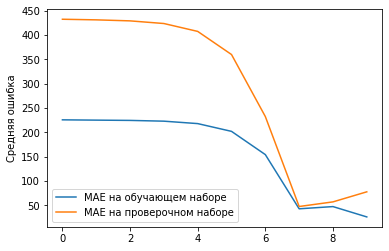

In [51]:
plt.plot(history_3.history['mae'][:], 
         label='MAE на обучающем наборе')
plt.plot(history_3.history['val_mae'][:], 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [52]:
hist_val_3 = history_3.history['val_mae']
hist_train_3 = history_3.history['mae']

Epoch 1/10
13/13 [==============================] - 0s 9ms/step - loss: 793.5006 - mae: 22.9090 - val_loss: 5197.7988 - val_mae: 52.5913
Epoch 2/10
13/13 [==============================] - 0s 8ms/step - loss: 804.0599 - mae: 22.4200 - val_loss: 6023.4995 - val_mae: 57.2842
Epoch 3/10
13/13 [==============================] - 0s 8ms/step - loss: 723.9252 - mae: 21.2914 - val_loss: 6295.2085 - val_mae: 58.8069
Epoch 4/10
13/13 [==============================] - 0s 8ms/step - loss: 738.2273 - mae: 21.5482 - val_loss: 5736.8193 - val_mae: 55.7466
Epoch 5/10
13/13 [==============================] - 0s 8ms/step - loss: 724.6585 - mae: 21.2594 - val_loss: 5899.1006 - val_mae: 56.7080
Epoch 6/10
13/13 [==============================] - 0s 8ms/step - loss: 716.1372 - mae: 21.1714 - val_loss: 5751.6240 - val_mae: 55.8841
Epoch 1/10
13/13 [==============================] - 0s 10ms/step - loss: 714.2714 - mae: 21.1342 - val_loss: 5649.5439 - val_mae: 55.3046
Epoch 2/10
13/13 [======================

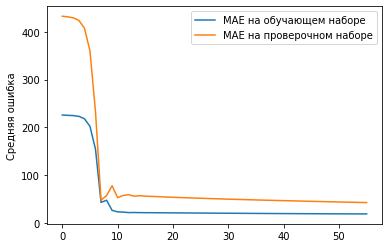

Epoch 1/10
13/13 [==============================] - 0s 9ms/step - loss: 566.2189 - mae: 18.5549 - val_loss: 3487.5820 - val_mae: 42.1120
Epoch 2/10
13/13 [==============================] - 0s 8ms/step - loss: 563.8968 - mae: 18.5273 - val_loss: 3457.7595 - val_mae: 41.8675
Epoch 3/10
13/13 [==============================] - 0s 8ms/step - loss: 561.6122 - mae: 18.4996 - val_loss: 3428.7434 - val_mae: 41.6253
Epoch 4/10
13/13 [==============================] - 0s 8ms/step - loss: 559.3646 - mae: 18.4717 - val_loss: 3400.5073 - val_mae: 41.4128
Epoch 5/10
13/13 [==============================] - 0s 8ms/step - loss: 557.1517 - mae: 18.4435 - val_loss: 3373.0234 - val_mae: 41.2511
Epoch 6/10
13/13 [==============================] - 0s 8ms/step - loss: 554.9727 - mae: 18.4152 - val_loss: 3346.2676 - val_mae: 41.1003
Epoch 7/10
13/13 [==============================] - 0s 8ms/step - loss: 552.8264 - mae: 18.3867 - val_loss: 3320.2092 - val_mae: 40.9503
Epoch 8/10
13/13 [=======================

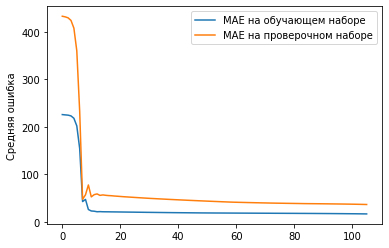

Epoch 1/10
13/13 [==============================] - 0s 9ms/step - loss: 447.7820 - mae: 16.6346 - val_loss: 2447.1101 - val_mae: 36.3834
Epoch 2/10
13/13 [==============================] - 0s 8ms/step - loss: 443.0302 - mae: 16.5425 - val_loss: 2421.6182 - val_mae: 36.2118
Epoch 3/10
13/13 [==============================] - 0s 8ms/step - loss: 438.0026 - mae: 16.4436 - val_loss: 2395.1375 - val_mae: 36.0281
Epoch 4/10
13/13 [==============================] - 0s 8ms/step - loss: 432.6845 - mae: 16.3387 - val_loss: 2367.6084 - val_mae: 35.8315
Epoch 5/10
13/13 [==============================] - 0s 8ms/step - loss: 427.0626 - mae: 16.2270 - val_loss: 2338.9802 - val_mae: 35.6426
Epoch 6/10
13/13 [==============================] - 0s 8ms/step - loss: 421.1234 - mae: 16.1125 - val_loss: 2309.1992 - val_mae: 35.4597
Epoch 7/10
13/13 [==============================] - 0s 8ms/step - loss: 414.8562 - mae: 15.9893 - val_loss: 2278.2209 - val_mae: 35.2621
Epoch 8/10
13/13 [=======================

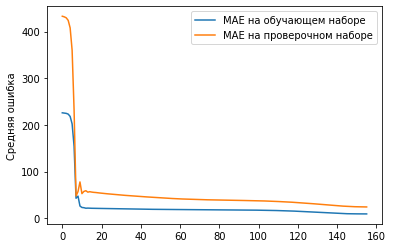

Epoch 1/10
13/13 [==============================] - 0s 9ms/step - loss: 135.2239 - mae: 9.0672 - val_loss: 875.3636 - val_mae: 23.9597
Epoch 2/10
13/13 [==============================] - 0s 8ms/step - loss: 134.5456 - mae: 9.0534 - val_loss: 869.7263 - val_mae: 23.9193
Epoch 3/10
13/13 [==============================] - 0s 8ms/step - loss: 133.9272 - mae: 9.0393 - val_loss: 864.7313 - val_mae: 23.8821
Epoch 4/10
13/13 [==============================] - 0s 8ms/step - loss: 133.3600 - mae: 9.0287 - val_loss: 860.3132 - val_mae: 23.8479
Epoch 5/10
13/13 [==============================] - 0s 8ms/step - loss: 132.8338 - mae: 9.0175 - val_loss: 856.4138 - val_mae: 23.8164
Epoch 6/10
13/13 [==============================] - 0s 8ms/step - loss: 132.3433 - mae: 9.0058 - val_loss: 852.9731 - val_mae: 23.7874
Epoch 7/10
13/13 [==============================] - 0s 8ms/step - loss: 131.8832 - mae: 8.9935 - val_loss: 849.9454 - val_mae: 23.7605
Epoch 8/10
13/13 [==============================] - 0s 

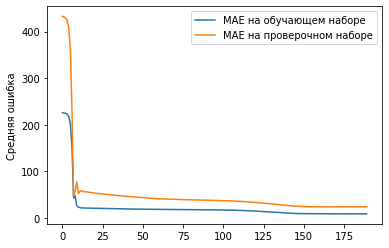

Epoch 1/10
13/13 [==============================] - 0s 11ms/step - loss: 123.7273 - mae: 8.6502 - val_loss: 836.8621 - val_mae: 24.1194
Epoch 2/10
13/13 [==============================] - 0s 8ms/step - loss: 123.5137 - mae: 8.6403 - val_loss: 837.4951 - val_mae: 24.1440
Epoch 3/10
13/13 [==============================] - 0s 8ms/step - loss: 123.3079 - mae: 8.6312 - val_loss: 838.1278 - val_mae: 24.1677
Epoch 4/10
13/13 [==============================] - 0s 8ms/step - loss: 123.1006 - mae: 8.6224 - val_loss: 838.8293 - val_mae: 24.1916
Epoch 5/10
13/13 [==============================] - 0s 8ms/step - loss: 122.8972 - mae: 8.6136 - val_loss: 839.5613 - val_mae: 24.2150
Epoch 6/10
13/13 [==============================] - 0s 8ms/step - loss: 122.6992 - mae: 8.6046 - val_loss: 840.3008 - val_mae: 24.2377
Epoch 1/10
13/13 [==============================] - 0s 9ms/step - loss: 122.4991 - mae: 8.5957 - val_loss: 841.1138 - val_mae: 24.2607
Epoch 2/10
13/13 [==============================] - 0s

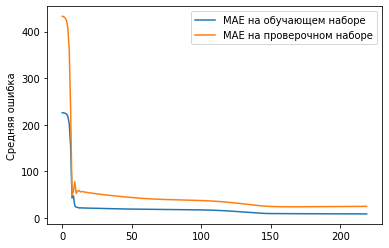

In [53]:
for iteration in range(num_iterations):
  history_3 = model_3.fit(dataset_train,
                      epochs=epochs,
                      validation_data=dataset_val,
                      callbacks=[early_stop])

  hist_val_3.extend(history_3.history['val_mae'][:])
  hist_train_3.extend(history_3.history['mae'][:])

  if (iteration + 1) % 5 == 0:
    plt.plot(hist_train_3, 
            label='MAE на обучающем наборе')
    plt.plot(hist_val_3, 
            label='MAE на проверочном наборе')

    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

In [54]:
pred_3 = model_3.predict(dataset_train).flatten()
pred_val_3 = model_3.predict(dataset_val).flatten()

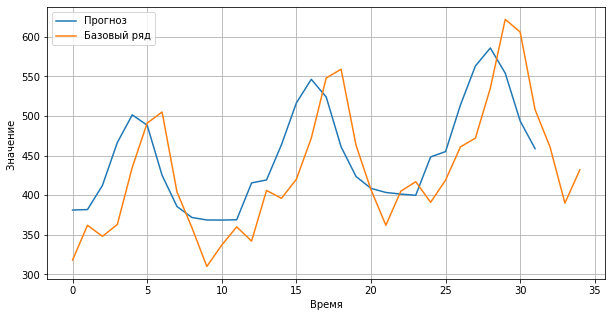

In [55]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val_3[future + start: future + start + step], 
         label='Прогноз')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

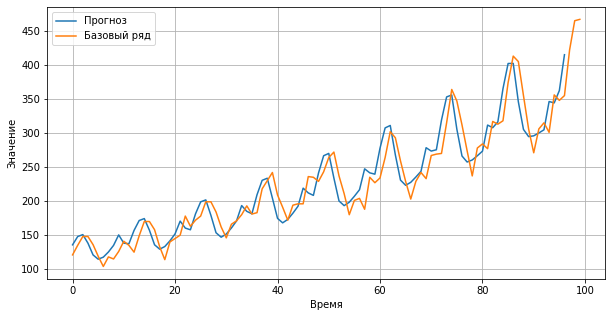

In [56]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_3[future + start: future + train_size], 
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [57]:
train_loss_3, train_m_3 = model_3.evaluate(dataset_train)
test_loss_3, test_m_3 = model_3.evaluate(dataset_val)
print(f'train_loss: {train_loss_3}, train_m: {train_m_3}')
print(f'test_loss: {test_loss_3}, test_m: {test_m_3}')

model.append('GRU')
train_m.append(round(train_m_3,2))
test_m.append(round(test_m_3,2))

5/5 [==============================] - 0s 2ms/step - loss: 867.3436 - mae: 24.7032
train_loss: 100.32567596435547, train_m: 7.812819957733154
test_loss: 867.3435668945312, test_m: 24.703218460083008


In [58]:
results['model'] = model
results['train_m'] = train_m
results['test_m'] = test_m

In [59]:
results

,model,train_m,test_m
0,SimpleRNN,9.58,27.15
1,LSTM,7.76,24.94
2,GRU,7.81,24.70


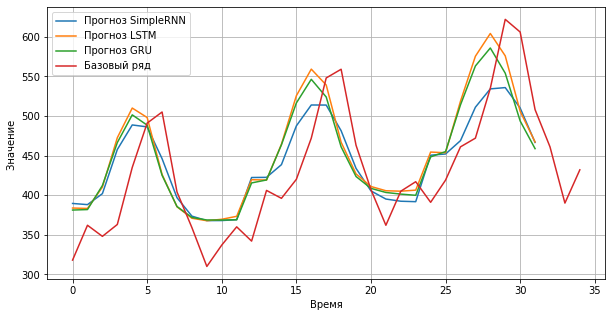

In [60]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val_1[future + start: future + start + step], 
         label='Прогноз SimpleRNN')
plt.plot(pred_val_2[future + start: future + start + step], 
         label='Прогноз LSTM')
plt.plot(pred_val_3[future + start: future + start + step], 
         label='Прогноз GRU')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

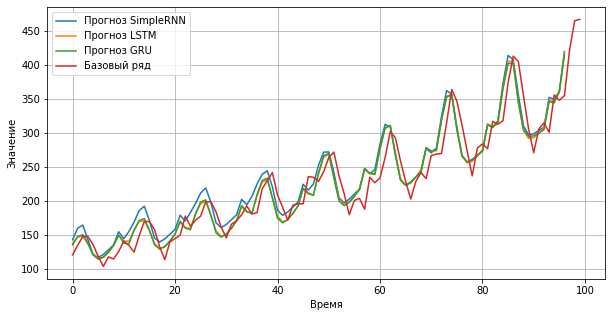

In [61]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_1[future + start: future + train_size], 
         label='Прогноз SimpleRNN')
plt.plot(pred_2[future + start: future + train_size], 
         label='Прогноз LSTM')
plt.plot(pred_3[future + start: future + train_size], 
         label='Прогноз GRU')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()